<a href="https://colab.research.google.com/github/Anish03112003/Bedrock_Multimodal_RAG/blob/main/Bedrock_Multimodal_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tabula-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 103.6 MB/s eta 0:00:00


In [ ]:
!pip install jpype1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 6.2 MB/s eta 0:00:00


In [ ]:
%pip install boto3
%pip install pymupdf
%pip install langchain
%pip install tqdm
%pip install ipython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.6 MB/s eta 0:00:00


In [ ]:
import boto3
import tabula
import os
import json
import base64
import pymupdf
import numpy as np
from tqdm import tqdm
import logging
from botocore.exceptions import ClientError
from langchain.text_splitter import RecursiveCharacterTextSplitter
from IPython import display

logger = logging.getLogger(__name__)
logger.setLevel(logging. ERROR)

In [ ]:
!pip install pdf2image

In [ ]:
from pdf2image import convert_from_path
import os

def pdf2imgs(pdf_path, output_base_dir):
    """
    Converts all pages of the given PDF into PNG images and saves them in a
    dedicated subfolder under output_base_dir named after the PDF file (without extension).

    Args:
        pdf_path (str): Full path to the input PDF file.
        output_base_dir (str): Base directory to store all page images.

    Returns:
        str: Path to the subdirectory where the page images were saved.
    """
    # Extract PDF filename (without extension)
    pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]

    # Create a dedicated subdirectory for this PDF's images
    output_dir = os.path.join(output_base_dir, pdf_name)
    os.makedirs(output_dir, exist_ok=True)

    # Convert PDF to images
    images = convert_from_path(pdf_path)

    # Save each page as a PNG
    for i, image in enumerate(images):
        image_path = os.path.join(output_dir, f"page_{i:03d}.png")
        image.save(image_path, 'PNG')

    return output_dir

In [ ]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 1s (137 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
pdfs_dir = "./pdfs"

# Define directories to store the extracted text, images, tables, and page images
image_save_dir = "data/processed_images"
text_save_dir = "data/processed_text"
table_save_dir = "data/processed_tables"
page_images_save_dir = "data/processed_page_images"

chunk_size = 700
overlap = 200

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=overlap,
    length_function=len,
)

pdf_files = [f for f in os.listdir(pdfs_dir) if f.endswith('.pdf')]

items = []

for pdf_filename in tqdm(pdf_files, desc="Processing PDFs"):
    filepath = os.path.join(pdfs_dir, pdf_filename)
    doc = pymupdf.open(filepath)
    num_pages = len(doc)

    # Save full PDF pages as images to a dedicated subfolder
    pdf_page_images_dir = pdf2imgs(filepath, page_images_save_dir)

    for page_num in range(num_pages):
        page = doc[page_num]
        text = page.get_text()

        # Step 1: Extract tables
        try:
            tables = tabula.read_pdf(filepath, pages=page_num + 1, multiple_tables=True)
            if tables:
                for table_idx, table in enumerate(tables):
                    table_text = "\n".join([" | ".join(map(str, row)) for row in table.values])
                    os.makedirs(table_save_dir, exist_ok=True)
                    table_file_name = f"{table_save_dir}/{pdf_filename}_table_{page_num}_{table_idx}.txt"
                    with open(table_file_name, 'w') as f:
                        f.write(table_text)
                    items.append({
                        "page": page_num,
                        "type": "table",
                        "text": table_text,
                        "path": table_file_name
                    })
                    text = text.replace(table_text, "")
        except Exception as e:
            print(f"Error extracting tables from page {page_num} of {pdf_filename}: {str(e)}")

        # Step 2: Extract text
        chunks = text_splitter.split_text(text)
        os.makedirs(text_save_dir, exist_ok=True)
        for i, chunk in enumerate(chunks):
            text_file_name = f"{text_save_dir}/{pdf_filename}_text_{page_num}_{i}.txt"
            with open(text_file_name, 'w') as f:
                f.write(chunk)
            items.append({
                "page": page_num,
                "type": "text",
                "text": chunk,
                "path": text_file_name
            })

        # Step 3: Extract inline images
        images = page.get_images()
        os.makedirs(image_save_dir, exist_ok=True)
        for idx, image in enumerate(images):
            xref = image[0]
            pix = pymupdf.Pixmap(doc, xref)
            image_name = f"{image_save_dir}/{pdf_filename}_image_{page_num}_{idx}_{xref}.png"
            pix.save(image_name)
            with open(image_name, 'rb') as f:
                image_data = base64.b64encode(f.read()).decode('utf8')
            items.append({
                "page": page_num,
                "type": "image",
                "path": image_name,
                "image": image_data
            })

        # Step 4: Save full-page image (already saved earlier)
        page_path = os.path.join(pdf_page_images_dir, f"page_{page_num:03d}.png")
        if os.path.exists(page_path):
            with open(page_path, 'rb') as f:
                page_image = base64.b64encode(f.read()).decode('utf8')
            items.append({
                "page": page_num,
                "type": "page",
                "path": page_path,
                "image": page_image
            })

Processing PDFs: 100%|██████████| 2/2 [00:19<00:00,  9.57s/it]


In [ ]:
[i for i in items if i['type'] == 'text']

[{'page': 0,
  'type': 'text',
  'text': 'Test Case E13V01 – Tank with Plant Structure\nInformation\nTank with tag name\n(no information about tag name parts: prefix, sequence number, suffix).\nThe tank is part of a PlantSection with PlantSectionName „Brewing Section“.\nThe PlantSection s part of the following hierarchy:\n• Enterprise „DEXPI Beer Inc.“\n• Site „Cologne“\n• IndustrialComplex „Beer Complex“\n• ProcessPlant „Kölsch Plant“\n• PlantSection „Brewing Section“\nT1301',
  'path': 'data/processed_text/E14V01.pdf_text_0_0.txt'},
 {'page': 0,
  'type': 'text',
  'text': 'C01V04 \nThis is the full DEXPI \nReference P&ID. \nAlle Disciplines are\nincluded:\n•\nEquipment\n•\nPiping\n•\nInstrumentation & \nElectrical',
  'path': 'data/processed_text/C01V04.pdf_text_0_0.txt'},
 {'page': 1,
  'type': 'text',
  'text': 'Graphics of C01V04',
  'path': 'data/processed_text/C01V04.pdf_text_1_0.txt'},
 {'page': 2,
  'type': 'text',
  'text': 'Tables of C01V04',
  'path': 'data/processed_text/

In [ ]:
[i for i in items if i['type'] == 'image']

[{'page': 0,
  'type': 'image',
  'path': 'data/processed_images/E14V01.pdf_image_0_0_14.png',
  'image': 'iVBORw0KGgoAAAANSUhEUgAAAV8AAAG8CAIAAAD2BzH6AAAACXBIWXMAAA7EAAAOxAGVKw4bAAARXElEQVR4nO3dMW8b2b3GYX0Nf4ftAveutknhKq2Lhbtb28B2aVQtsI27AAKiD0DgNrdQoc5NAAMqUhjqAnjhJhCChQEHWxi+f/touWPykCIlSnw58zxF4CiUNOLM/OacMyPl6DNAz9G+NwAIpQ5AnzoAfeoA9KkD0KcOQJ86AH3qAPSpA9CnDkCfOgB96gD0qQPQpw5AnzoAfeoA9KkD0KcOQJ86AH3qAPSpA9CnDlP07t27y57ZQPcF9Yn73nYejjqMx8ePH9s5/Pr163aGv/jq6dOnR/fm+fPn7bu071jfum3Dvt8MdkAdDs/V1VW7zp+enrYz8/Hjx+vP4RffevXq1azn4uKindv1j+4L6hMXvtT671sb1l5Wm9rGI7Xx+37/2JQ6pJu3oJ2Z3ZOwRgfDk/Ds7Kyd5DWaeMiNLPWtN8nWvFBmK8nUIc76FrQQzMfw+97YTc3nO7XxNRnpzlCOj4/b+MX4IoQ67F+dDHVK1PV2+bQ50BZsooYMbf5SUej+4PXxGokYWeyROuxHHfR1wtcAYWHJsM6TysT4WrCJ+RxqYUrSFi/aNGTf2zgt6vBw2qFfl8SF2fj80H+wZYKDUAGtsUO9Xd2A1rjD23Xf1OF+1RFcA4GFItS/27DZxXBDNayot3F58lX/td5G6xT3RB3uRbvuDQ/lKkLNI+oQdyjfUQW3LVgM394aX1Q7LFLsljrsUltcHI6E2zDYUXtPKrVt9rFQ4doR+960MVCHu+rOHdrEwTDhwSzvhTZ9qw9anrg1dbi9djguX7UcjvtVu2DhZlDtJqOJW1CHrdU0oQ6++

In [ ]:
# Install python-dotenv (if not already installed)
!pip install python-dotenv

import os
from dotenv import load_dotenv
import boto3

# Load environment variables from .env file
load_dotenv(dotenv_path='.env')  # Ensure .env file is uploaded to Colab environment

# Fetch values from environment
aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")
aws_session_token = os.getenv("AWS_SESSION_TOKEN")
region_name = os.getenv("AWS_REGION", "us-west-2")  # default fallback

# Create a session using credentials from environment
session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    aws_session_token=aws_session_token,
    region_name=region_name
)

# Create the Bedrock Runtime client
bedrock_client = session.client(service_name="bedrock")

print(bedrock_client.get_foundation_model(modelIdentifier='amazon.titan-embed-image-v1'))

{'ResponseMetadata': {'RequestId': 'f6723f40-9fda-4e84-8ed7-110713bc5f93', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 07 May 2025 10:32:08 GMT', 'content-type': 'application/json', 'content-length': '543', 'connection': 'keep-alive', 'x-amzn-requestid': 'f6723f40-9fda-4e84-8ed7-110713bc5f93'}, 'RetryAttempts': 0}, 'modelDetails': {'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-embed-image-v1', 'modelId': 'amazon.titan-embed-image-v1', 'modelName': 'Titan Multimodal Embeddings G1', 'providerName': 'Amazon', 'inputModalities': ['TEXT', 'IMAGE'], 'outputModalities': ['EMBEDDING'], 'customizationsSupported': [], 'inferenceTypesSupported': ['ON_DEMAND'], 'modelLifecycle': {'status': 'ACTIVE'}}}


In [ ]:
import boto3
import json
from botocore.exceptions import ClientError
from tqdm import tqdm

# Create the session and client
bedrock_client = session.client(service_name="bedrock-runtime", region_name = "us-west-2")
model_id = "amazon.titan-embed-image-v1"

def generate_multimodal_embeddings(prompt=None, image=None, output_embedding_length=384):
    if not prompt and not image:
        raise ValueError("Provide either a text prompt or a base64 image.")

    # Build payload with correct keys
    body = {
        "embeddingConfig": {
            "outputEmbeddingLength": output_embedding_length
        }
    }

    if prompt:
        body["inputText"] = prompt
    if image:
        body["inputImage"] = image

    try:
        response = bedrock_client.invoke_model(
            modelId=model_id,
            body=json.dumps(body),
            accept="application/json",
            contentType="application/json"
        )
        result = json.loads(response["body"].read())
        return result.get("embedding")

    except ClientError as err:
        error_message = err.response.get('Error', {}).get('Message', str(err))
        print(f"Couldn't invoke Titan embedding model. Error: {error_message}")

        # Debug log with truncated image
        debug_body = json.loads(json.dumps(body))  # deep copy
        if "inputImage" in debug_body and isinstance(debug_body["inputImage"], str):
            debug_body["inputImage"] = debug_body["inputImage"][:50] + "..."
        print(f"Request body that caused error (truncated): {json.dumps(debug_body)}")
        return None

In [ ]:
# Generate embeddings for a collection of items
embedding_vector_dimension = 384
for item in tqdm(items, desc="Generating embeddings"):
    try:
        if item['type'] == 'text' or item['type'] == 'table':
            item['embedding'] = generate_multimodal_embeddings(
                prompt=item['text'],
                output_embedding_length=embedding_vector_dimension
            )
        elif item.get('image'):
            item['embedding'] = generate_multimodal_embeddings(
                image=item['image'],
                output_embedding_length=embedding_vector_dimension
            )
        else:
            print(f"Skipping item due to missing data: {item}")
    except Exception as e:
        print(f"Error processing item: {e}")

Generating embeddings: 100%|██████████| 14/14 [00:05<00:00,  2.55it/s]


In [ ]:
all_embeddings = np.array([item['embedding'] for item in items])

In [ ]:
all_embeddings.shape

(14, 384)

In [ ]:
len(items)

14

In [ ]:
items[3]

{'page': 0,
 'type': 'text',
 'text': 'C01V04 \nThis is the full DEXPI \nReference P&ID. \nAlle Disciplines are\nincluded:\n•\nEquipment\n•\nPiping\n•\nInstrumentation & \nElectrical',
 'path': 'data/processed_text/C01V04.pdf_text_0_0.txt',
 'embedding': [0.006111285,
  0.006778456,
  -0.0883868,
  -0.03010275,
  0.096926585,
  0.078566045,
  -0.032664686,
  0.120411,
  -0.013023175,
  0.010567986,
  0.019321268,
  0.020175247,
  -0.009233645,
  -0.008753282,
  0.008806655,
  -0.07472314,
  -0.049103774,
  -0.037575062,
  -0.024338393,
  -0.019428015,
  -0.0320242,
  -0.026259845,
  -0.03330517,
  0.07386916,
  -0.010781481,
  0.015158122,
  -0.070880234,
  0.005844417,
  0.00086065044,
  0.031597212,
  0.0065649613,
  0.061486468,
  0.01921452,
  -0.0028288045,
  -0.075150125,
  -0.009553887,
  0.016759332,
  -0.054227646,
  0.054014154,
  0.063194424,
  -0.064475395,
  0.082835935,
  -0.10503938,
  0.034372643,
  -0.0031890767,
  -0.0360806,
  -0.096926585,
  -0.012382692,
  0.095645

In [ ]:
!pip install opensearch-py requests-aws4auth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.5/353.5 kB 9.0 MB/s eta 0:00:00


## Opensearch Storage Retrieval

In [ ]:
from opensearchpy import OpenSearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth
import boto3
import json

# Configuration
region = "us-west-2"
service = "aoss"
host = "https://8cii5p7a374yamz7duxf.us-west-2.aoss.amazonaws.com"
index_name = "multimodal-storage"
embedding_dimension = 384

# AWS auth (use your existing session if applicable)
session = boto3.Session()
credentials = session.get_credentials()
auth = AWS4Auth(
    credentials.access_key,
    credentials.secret_key,
    region,
    service,
    session_token=credentials.token
)

# OpenSearch client
client = OpenSearch(
    hosts=[{'host': host.replace("https://", ""), 'port': 443}],
    http_auth=auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection
)

# Define index mapping with knn_vector
index_mapping = {
    "settings": {
        "index": {
            "knn": True  # Enables k-NN search
        }
    },
    "mappings": {
        "properties": {
            "embedding": {
                "type": "knn_vector",
                "dimension": embedding_dimension,
                "method": {
                    "name": "hnsw",
                    "space_type": "l2",
                    "engine": "faiss"
                }
            },
            "type": {"type": "keyword"},
            "text": {"type": "text"}
        }
    }
}

# Create index
if not client.indices.exists(index=index_name):
    response = client.indices.create(index=index_name, body=index_mapping)
    print("Index created:", response)
else:
    print("Index already exists")

Index already exists


In [ ]:
for i, item in enumerate(items):
    doc = {
        "type": item.get("type"),
        "embedding": item["embedding"]
    }

    # Add common fields
    if "text" in item:
        doc["text"] = item["text"]
    if "page" in item:
        doc["page"] = item["page"]

    # Conditionally store image data if available
    if item.get("image"):
        doc["image"] = item["image"]

    # Index the document in OpenSearch
    client.index(index=index_name, body=doc)

In [ ]:
import boto3
import json
from botocore.exceptions import ClientError
import logging

logger = logging.getLogger(__name__)

region_name = 'us-west-2'

def invoke_claude_3_multimodal(prompt, images, image_types):
    """
    Invoke the Claude-3 multimodal model from Anthropic using AWS Bedrock runtime.

    Args:
        prompt (str): The text prompt to provide to the model.
        images (list): A list of base64-encoded image data.
        image_types (list): A list of MIME types corresponding to the images.

    Returns:
        str: The model's response text.

    Raises:
        ClientError: If the model invocation fails.
    """

    # Initialize the Amazon Bedrock runtime client
    client = boto3.client(service_name="bedrock-runtime", region_name=region_name)
    model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

    # Prepare the multimodal prompt message
    message_content = []

    # Add each image to the message content
    for image, img_type in zip(images, image_types):
        message_content.append({
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": img_type,
                "data": image
            }
        })

    # Add the text prompt
    message_content.append({"type": "text", "text": prompt})

    # Construct the request body
    request_body = {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 2048,
        "temperature": 0.2,
        "top_p": 1.0,
        "top_k": 250,
        "messages": [
            {
                "role": "user",
                "content": message_content
            }
        ]
    }

    # Invoke the model
    try:
        response = client.invoke_model(
            modelId=model_id,
            body=json.dumps(request_body),
            contentType="application/json",
            accept="application/json"
        )

        result = json.loads(response.get("body").read())
        return result['content'][0]['text']

    except ClientError as err:
        logger.error(
            "Couldn't invoke Claude 3 %s model. Here's why: %s: %s",
            model_id.split('.')[-1].capitalize(),
            err.response["Error"]["Code"],
            err.response["Error"]["Message"]
        )
        raise

In [ ]:
def generate_rag_response(prompt, matched_items):
    """
    Generate a RAG (Retrieval-Augmented Generation) response using matched text and image context.

    Args:
        prompt (str): The question or query to be answered.
        matched_items (list): List of retrieved items containing either 'text' or 'image' fields.

    Returns:
        str: Response from Claude 3 model.
    """

    # Create context
    text_context = ""
    image_context = []

    for item in matched_items:
        if item['type'] == 'text':
            text_context += f"{item.get('page', '')}. {item['text']}\n"
        elif item.get('image'):
            image_context.append(item['image'])

    # Only 5 images are supported by Claude 3 models
    if len(image_context) > 5:
        image_context = image_context[:5]

    final_prompt = f"""You are an expert assistant trained in interpreting industrial Piping and Instrumentation Diagrams (P&IDs).
You specialize in identifying and analyzing components such as pumps (e.g., P4711), tanks (e.g., T4750), heat exchangers (e.g., H1007),
and control systems. You understand and explain naming conventions used in real-world P&IDs, including:

- Equipment tags such as T (Tank), P (Pump), H (Heat Exchanger)
- Instrumentation identifiers like:
  - HS — Hand Switch
  - TICSA — Temperature Indicating Controller with Setpoint
  - PI — Pressure Indicator
  - PICSA — Pressure Indicating Controller with Setpoint
- Valve tags such as:
  - SV — Safety Valve
  - TV — Temperature Control Valve
- Piping codes such as:
  - MNb
  - 73KH12-25
  which represent piping class, routing ID, and diameter
- Connection points such as N1, N2, N3, etc., denoting ports on pumps, tanks, or exchangers

You are also able to:
- Trace process flows through piping and equipment
- Understand control signals via dashed lines
- Interpret flow direction, measurement points, and system functionality

<context>
{text_context}
</context>

The provided images are P&ID diagrams and contain:
- Standard ISA-compliant symbols and labels
- Instrument and equipment identifiers
- Process flow paths and control logic connections

<question>
{prompt}
</question>

Using the diagram and text, identify all relevant components, their relationships, and the control logic. Describe how these elements work together in the system.

Answer:"""



    return invoke_claude_3_multimodal(
        prompt=final_prompt,
        images=image_context,
        image_types=['image/png'] * len(image_context)
    )

### Match 1 — Type: `text` — Page: 2

Tables of C01V04

### Match 2 — Type: `text` — Page: 1

Graphics of C01V04

### Match 3 — Type: `image`

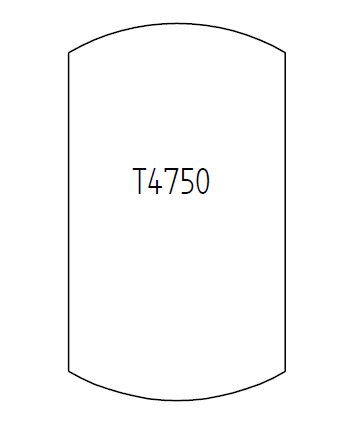

### Match 4 — Type: `page` — Page: 1

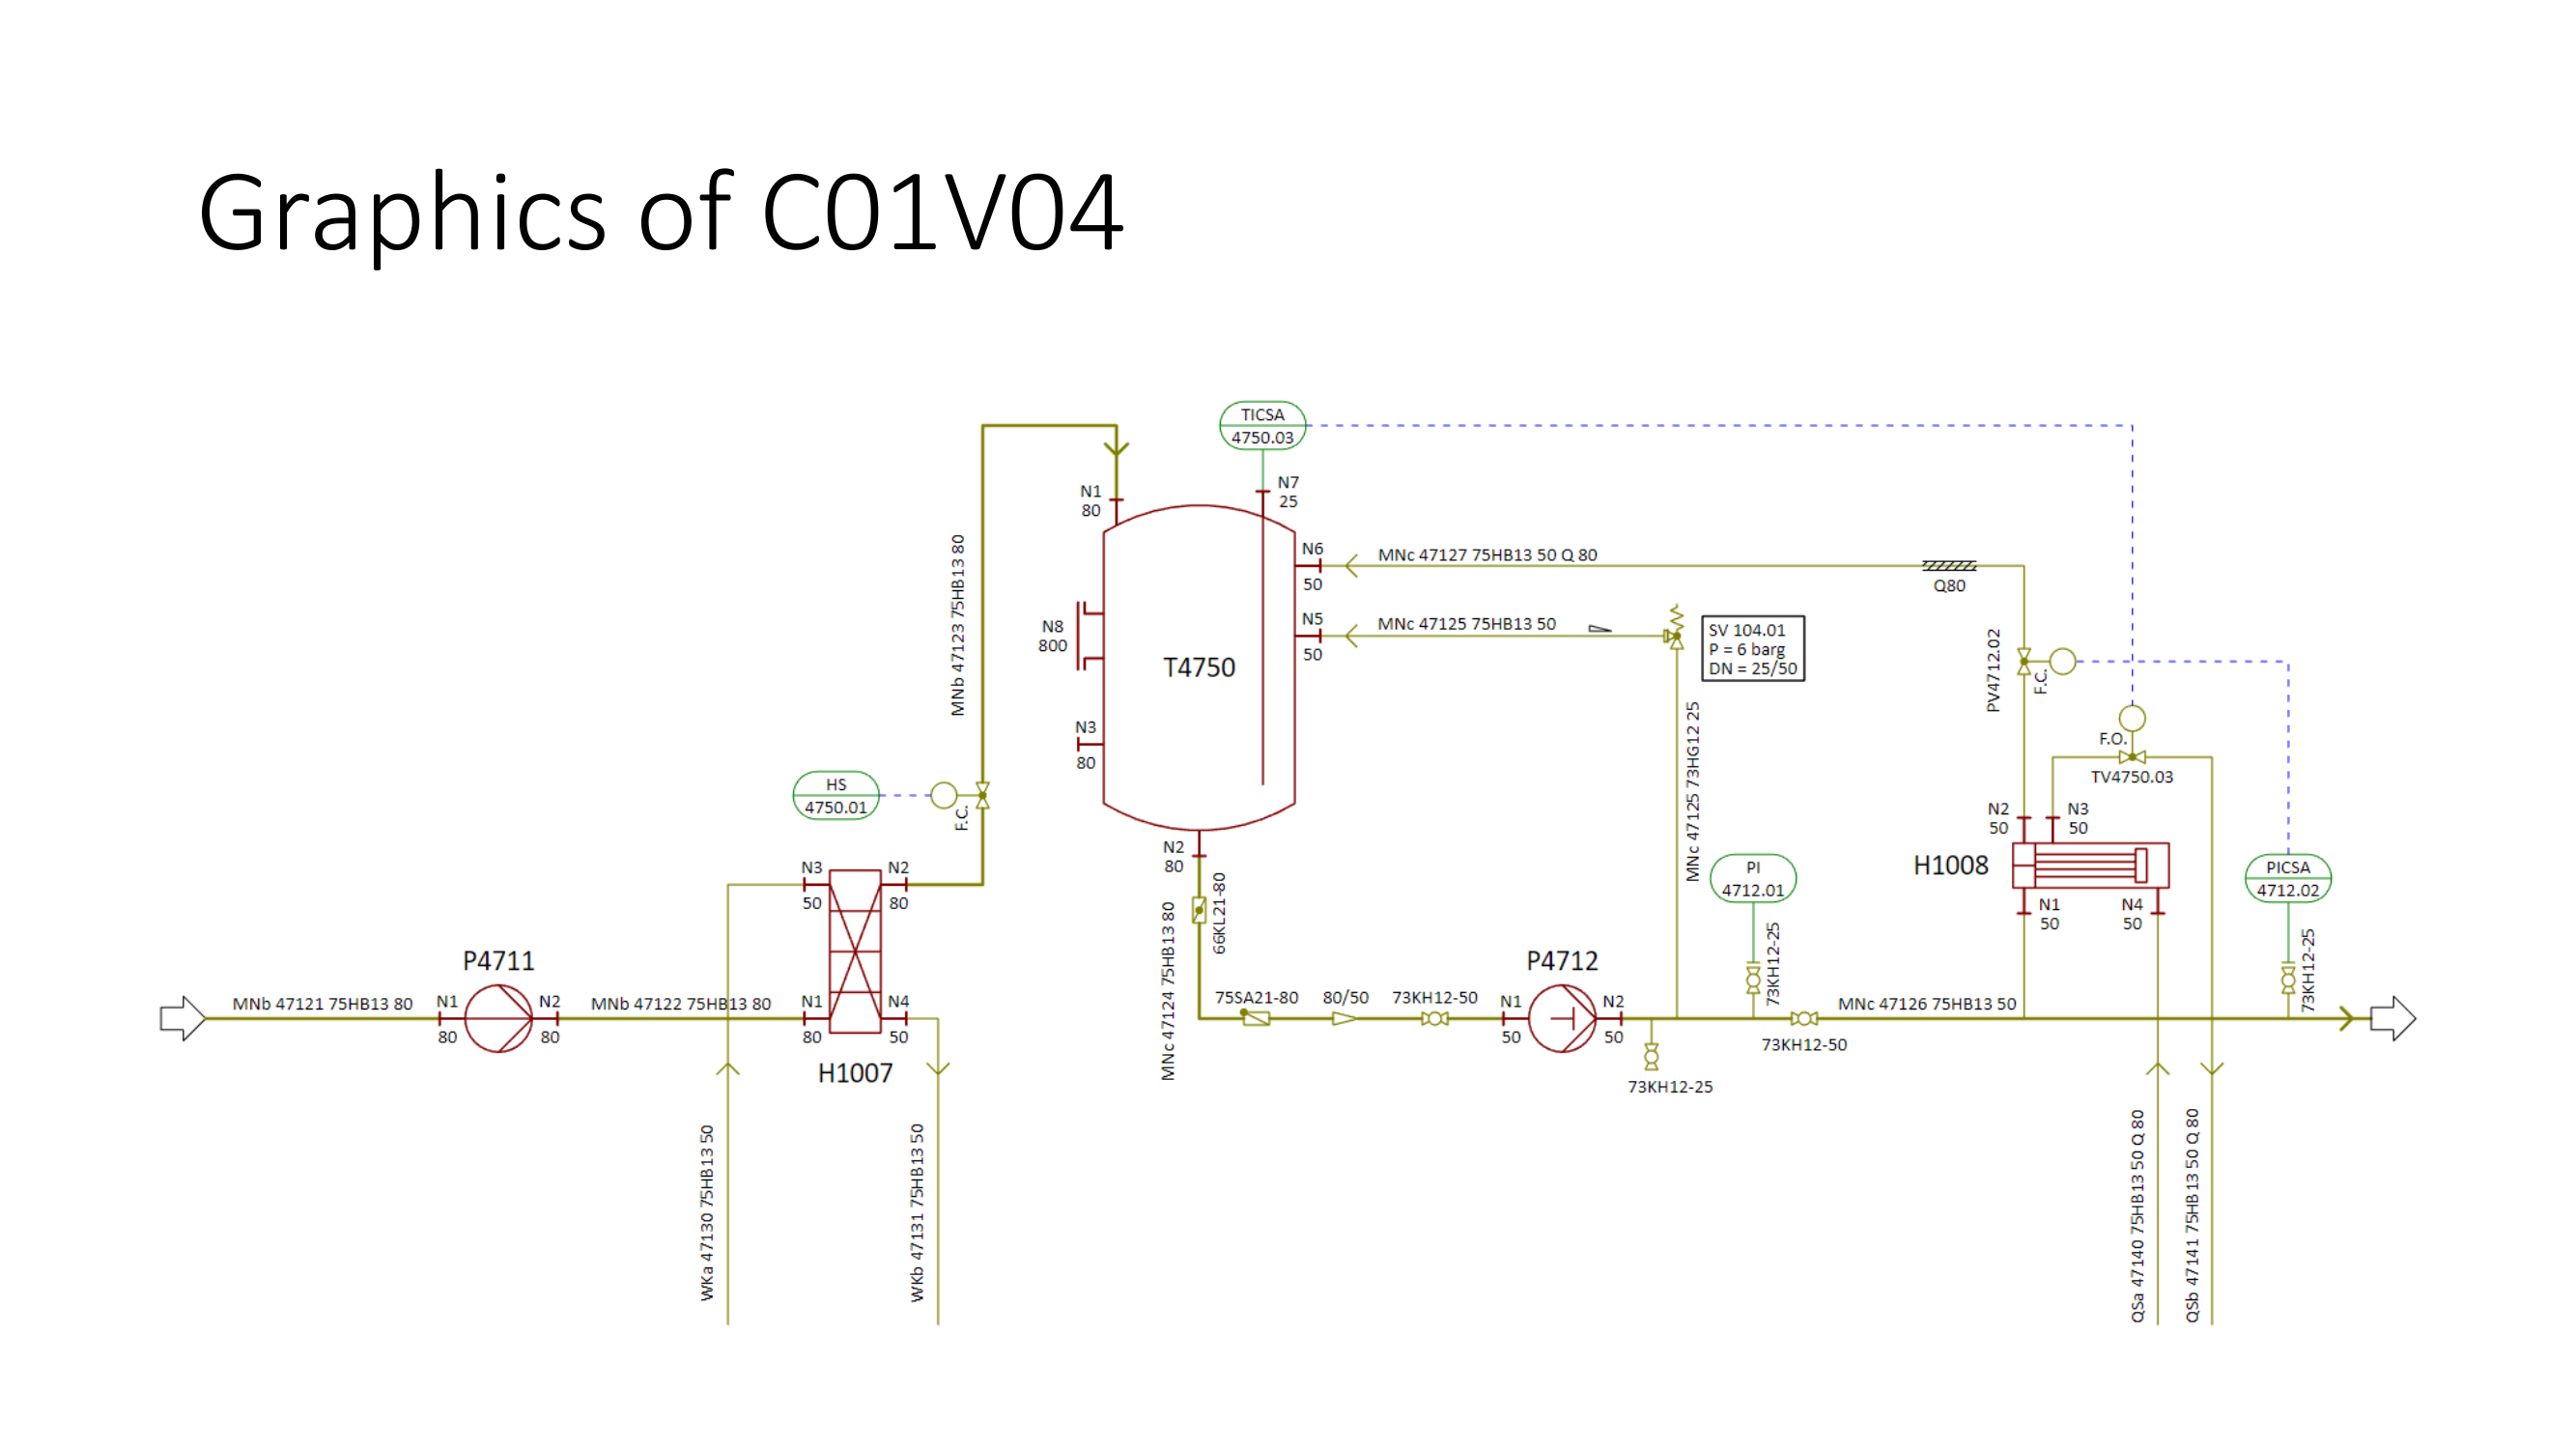

### Match 5 — Type: `image` — Page: 1

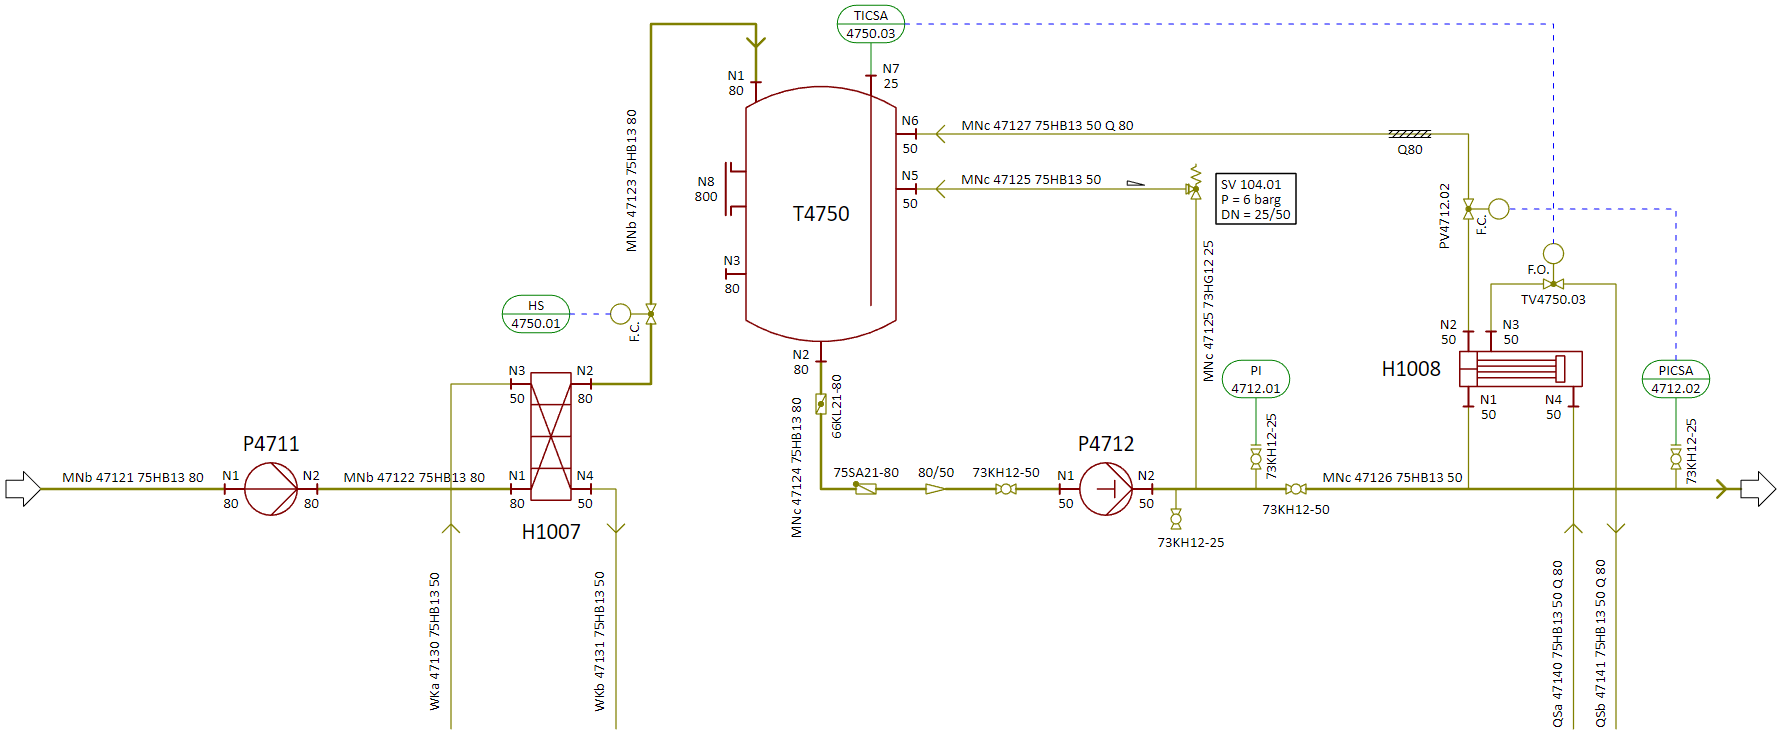

Based on the P&ID diagrams provided, T4750 (which appears to be a tank) is not directly connected to H1007 (a heat exchanger). However, they are part of the same process flow system with the following connections and components:

T4750 has inlet connections N7 and N6 from what seems to be a temperature control valve (TICSA 4750.03) and a line with MNC 47127 75HB13 SO Q 80 piping respectively. Its outlets are N5 (MNC 47125 75HB13 SO) which connects to the inlet of SV 104.01 (likely a safety/pressure relief valve), and N3 which connects to the suction side of P4712 (a pump).

P4712 has a discharge line (75A521-80) that connects to one inlet of H1007. The other inlet of H1007 comes from P4711 which draws suction from the discharge of T4750 via connections N2-N3-N2.

So while T4750 and H1007 are not directly connected, they are part of the same process flow where:
1) Fluid from T4750 is pumped by P4712 into one inlet of H1007
2) Additional fluid is supplied to the other H1007 inlet by P4711 after drawing from T4750

H1007 seems to be a heat exchanger receiving heated fluid from the two pump lines. The heated discharge from H1007 connects to downstream piping/equipment not shown.

The P&ID also depicts control instruments like HS 4750.01 (likely a hand switch), PI 4712.01 (pressure indicator), and PICSA 4712.02 providing monitoring and control for this part of the process system.

In [ ]:
from opensearchpy.helpers import scan
from IPython.display import Markdown, display, Image
import base64

def search_knn_opensearch(query_embedding, k=5):
    """
    Perform k-NN vector search using Amazon OpenSearch Serverless.

    Args:
        query_embedding (list): List of floats representing the embedding.
        k (int): Number of nearest neighbors to retrieve.

    Returns:
        list: List of matched documents from OpenSearch.
    """
    query = {
        "size": k,
        "query": {
            "knn": {
                "embedding": {
                    "vector": query_embedding,
                    "k": k
                }
            }
        }
    }

    response = client.search(index=index_name, body=query)
    hits = response["hits"]["hits"]
    return [hit["_source"] for hit in hits]

# Define query
query = "Is T4750 connected to H1007?"

# Step 1: Embed the query
query_embedding = generate_multimodal_embeddings(
    prompt=query,
    output_embedding_length=embedding_vector_dimension
)

# Step 2: Search top-k similar documents in OpenSearch
matched_items = search_knn_opensearch(query_embedding, k=5)

# Step 3: Display matched items
for i, item in enumerate(matched_items):
    item_type = item.get('type', 'unknown')
    page_number = item.get('page', None)
    display(Markdown(f"### Match {i+1} — Type: `{item_type}`" + (f" — Page: {page_number}" if page_number else "")))

    # Display content based on type
    if item_type in ['text', 'table']:
        text = item.get('text', '')
        display(Markdown(text if len(text) < 1000 else text[:1000] + "..."))

    elif item_type == 'image':
        image_data = item.get('image')
        if image_data:
            try:
                display(Image(data=base64.b64decode(image_data)))
            except Exception as e:
                print(f"Failed to render image for match {i+1}: {e}")
        else:
            print(f"No image data found for match {i+1}.")

    elif item_type == 'page':
        # A "page" might include both text and image content
        text = item.get('text', '')
        if text:
            display(Markdown(text if len(text) < 1000 else text[:1000] + "..."))

        image_data = item.get('image')
        if image_data:
            try:
                display(Image(data=base64.b64decode(image_data)))
            except Exception as e:
                print(f"Failed to render image for page match {i+1}: {e}")

    else:
        print(f"Unsupported item type: {item_type}")

# Step 4: Generate RAG response
response = generate_rag_response(query, matched_items)

# Step 5: Display final answer
display(Markdown(response))

## Faiss Storage and Retrieval

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 58.3 MB/s eta 0:00:00


In [ ]:
import faiss

# Create FAISS Index
index = faiss.IndexFlatL2(embedding_vector_dimension)

# Clear any pre-existing index
index.reset()

# Add embeddings to the index
index.add(np.array(all_embeddings, dtype=np.float32))

In [ ]:
query = "What is T4750 and what are its connections?"

# Generate embeddings for the query
query_embedding = generate_multimodal_embeddings(prompt=query, output_embedding_length=embedding_vector_dimension)

# Search for the nearest neighbors in the vector database
distances, result = index.search(np.array(query_embedding, dtype=np.float32).reshape(1,-1), k=5)

In [ ]:
result.flatten()

array([9, 6, 1, 8, 7])

### Match 1 — Type: `text`

Tables of C01V04

### Match 2 — Type: `text`

Graphics of C01V04

### Match 3 — Type: `image`

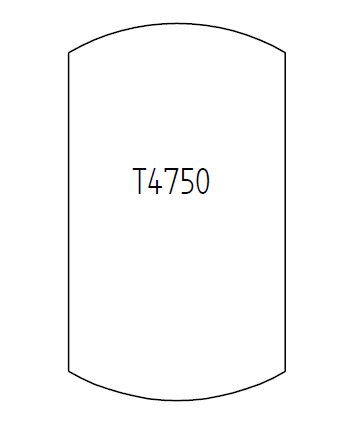

### Match 4 — Type: `page`

Unsupported item type: page


### Match 5 — Type: `image`

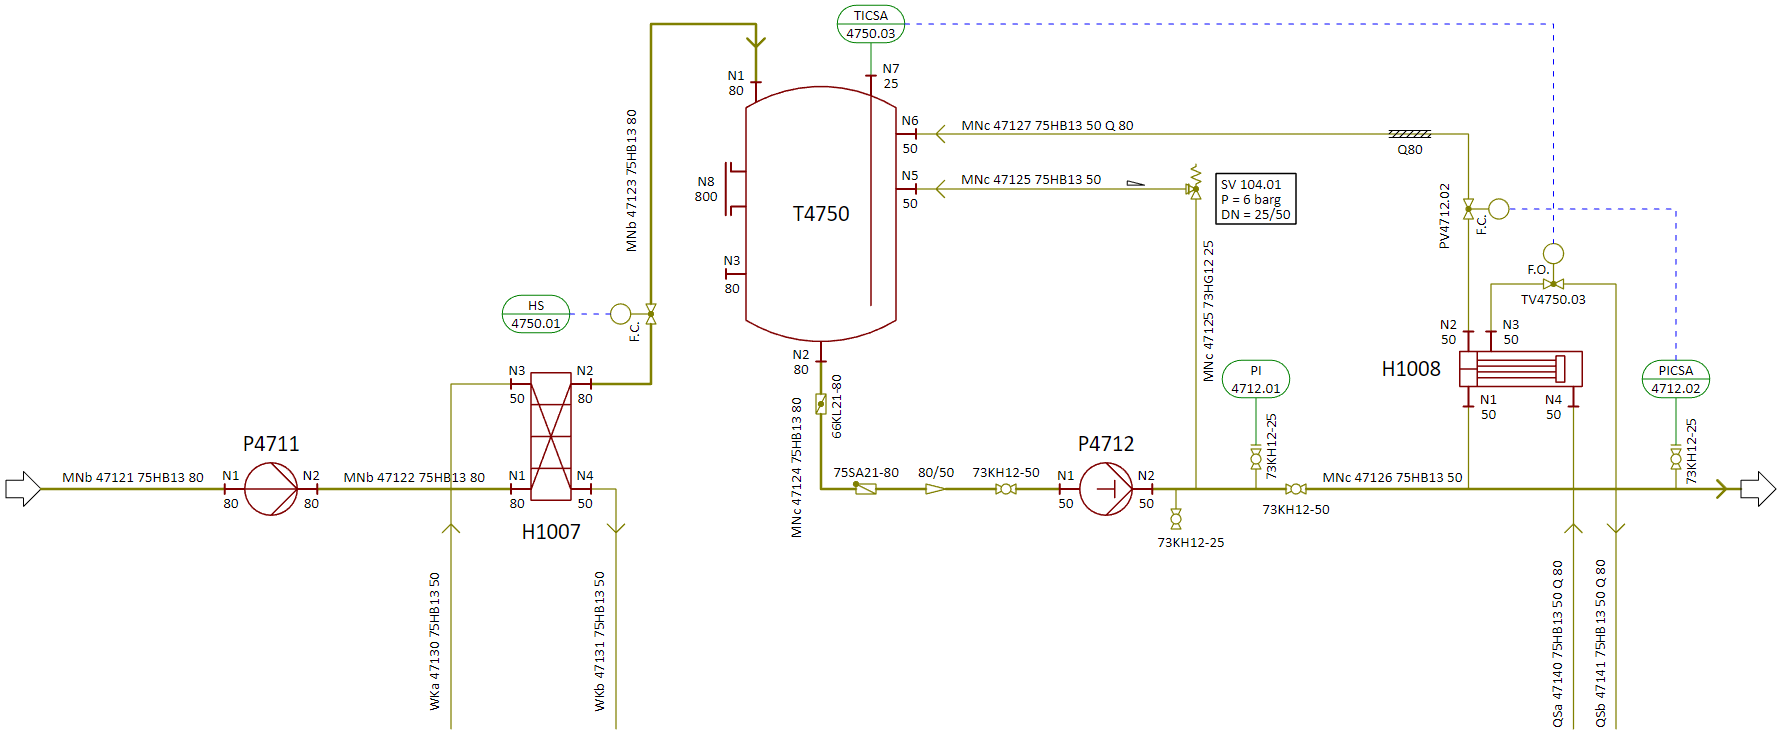

T4750 appears to be a tank or vessel in the P&ID diagram. It has several connections and instrumentation associated with it:

Inlet Connections:
- N7 (from TICSA 4750.03 temperature controller)
- N6 (from MNC 471227 75HB13 SO Q 80 piping)
- N5 (from MNC 471255 75HB13 SO piping)

Outlet Connections:
- N2 to P4712 pump
- N3 to H1008 heat exchanger

Instrumentation:
- N1 is connected to SV 104.01 safety/relief valve
- N4 is connected to TV4750.03 temperature control valve
- N8 is likely a level or pressure connection

The tank T4750 seems to receive inlet flows from the temperature controller TICSA 4750.03 and piping lines MNC 471227 and MNC 471255. Its contents are routed to the P4712 pump and H1008 heat exchanger. The safety valve SV 104.01 provides overpressure protection, while the temperature control valve TV4750.03 regulates temperature based on the control signal from the TICSA controller.

This arrangement allows T4750 to receive process flows, with temperature regulation before sending the material to downstream equipment like the pump and heat exchanger for further processing or heating/cooling. The instrumentation provides monitoring and control over key parameters like level, pressure, and temperature for safe and stable operation of the tank system.

In [ ]:
from IPython.display import Markdown, display, Image
import base64

# Retrieve the matched items
matched_items = [items [index] for index in result.flatten()]

for i, item in enumerate(matched_items):
    item_type = item.get('type', 'unknown')
    display(Markdown(f"### Match {i+1} — Type: `{item_type}`"))

    if item_type == 'text' or item_type == 'table':
        text = item.get('text', '')
        display(Markdown(text if len(text) < 1000 else text[:1000] + "..."))
    elif item_type == 'image':
        image_data = item.get('image')
        if image_data:
            try:
                display(Image(data=base64.b64decode(image_data)))
            except Exception as e:
                print(f"Failed to render image for match {i+1}: {e}")
        else:
            print(f"No image data found for match {i+1}.")
    else:
        print(f"Unsupported item type: {item_type}")

# Generate a response using the RAG pipeline
response = generate_rag_response(query, matched_items)

# Display the response
display(Markdown(response))